# Modelling process
For modeling process, I will use Support Vector Machine (SVM), reasons are justifed on report.

## Importing libraries needed for modelling process

In [1]:
# Import needed libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, validation_curve, learning_curve, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn_evaluation import plot
from sklearn.feature_selection import chi2

import joblib

from layer_data_access import tweet_data

## Methods needed for the process

In [2]:
def count_length(tweet):
    return len(tweet.replace(' ', ''))

def count_words(tweet):
    return len(tweet.split())

def get_specific_number_tweets(tweets, label, num_tweets = 1000):
    cond = tweets.label_id == label
    label_tweets = tweets[cond].reset_index(drop=True).copy()

    index = np.arange(label_tweets.shape[0])
    new_index = np.random.choice(index, num_tweets, replace = False)
    
    new_label_tweets = label_tweets.iloc[new_index,:].reset_index(drop=True).copy()
    
    return new_label_tweets

def plot_learning_curve(model, kfolds, X, y):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(model, X, y, train_sizes = train_sizes, cv = kfolds, scoring="accuracy")
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()

    print("\nLast scores:", val_train[-1], val_test[-1])

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

def my_feature_selection_chi(X, y, vectorizer, p_value_limit = 0.95):
    # For feature reduction, however it would not be used according to work mentioned below
    #  but keep it in the project just in case.
    X_names = vectorizer.get_feature_names()
    top = 10
    df_features = pd.DataFrame()
    for category in np.unique(y):
        stat, p = chi2(X, y == category)
        df_features = df_features.append(pd.DataFrame({"feature":X_names, "score":(1-p), "label":category}))
        df_features = df_features.sort_values(["label","score"], ascending=[True,False])
        df_features = df_features[df_features["score"]>p_value_limit]
    
    print("Summary of process...")
    for category in np.unique(y):
        print("# {}:".format(category))
        print("  . selected features:", len(df_features[df_features["label"] == category]))
        print("  . " + str(top) + " top features:", ", ".join(df_features[df_features["label"] == category]["feature"].values[:top]), end = '\n\n')
            
    #print("Total features selected:", len(df_features), "/", len(tf_vectorizer.get_feature_names()))
    return df_features["feature"].unique().tolist()
    
def create_model(learning_rate, epchos, penalty, l1_ratio):
    # Create Linear SVM algorithm, including a vectorizer
    return Pipeline([
                      ('tfidf', TfidfVectorizer(ngram_range = (1,1), lowercase = False, use_idf = True)),
                      ('svm', SGDClassifier(loss = 'hinge', alpha = learning_rate, max_iter = epchos, penalty = penalty, l1_ratio = l1_ratio, shuffle = True, random_state=1, early_stopping = True)) # Support Vector Machine
                    ])

def evaluate_model(model, X, y, repeats):
	# Prepare the cross-validation procedure.
    #  RepeatedStratifiedKFold is used to reduce the noise in the estimated model performance
    #  Keep 25% validation split
	cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = repeats, random_state = 1)
    
	# Evaluate model
	scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv, n_jobs = -1)
    
	return scores

def count_words(tweet):
    return len(tweet.split())


The batch that would be used for training model is the "covid_vaccine_global" that was a collection of tweets around the world with keywords "coronavirus" and "vaccine" (including synonyms or related words). Duplicated tweets have been excluded. NOTE: Tweets taken from Ireland would be used to classify the sentiment using the model that will be built.

In [16]:
# Get normalized tweets (global category)
#  Duplicated removed
access_data = tweet_data.tweet_data()
tweets = access_data.get_tweets_train_test()
del access_data

In [17]:
tweets.shape

(319627, 5)

In [18]:
# Remove all tweets with no lenght after normalization.
tweets['count_length'] = tweets['normalized_text'].apply(count_length)
cond = tweets['count_length'] > 2
print('Tweets left:', cond.sum())

tweets = tweets[cond].copy()

Tweets left: 319043


In [19]:
# Remove duplicated tweets
cond = tweets['cleaned_text'].duplicated()
print('Duplicated tweets:', cond.sum())

tweets = tweets[~cond].copy()
print('Tweets left:', len(tweets))

Duplicated tweets: 107788
Tweets left: 211255


In [20]:
# Print total of neutral, positive and negative 
#   where: 0 = Neutral, 1 = Positive, 2 = Negative
print(tweets.label.value_counts())

positive    81402
negative    65244
neutral     64609
Name: label, dtype: int64


The dataset is unbalanced. This could affect the performance of the model, thus the minimum total among classes would be taken that is negative 64609. Random functions (numpy library) would be used to select 64609 in each class.

In [21]:
tweets_taken = 64609
neutral_tweets = get_specific_number_tweets(tweets.copy(), 0, tweets_taken)
positive_tweets = get_specific_number_tweets(tweets.copy(), 1, tweets_taken)
negative_tweets = get_specific_number_tweets(tweets.copy(), 2, tweets_taken)

# Concat all tweets classes
new_tweets = pd.concat([neutral_tweets, positive_tweets, negative_tweets], axis = 0)
print(new_tweets.label.value_counts())
print('Total', len(new_tweets))

neutral     64609
positive    64609
negative    64609
Name: label, dtype: int64
Total 193827


In [22]:
# All data
X = new_tweets['normalized_text'].values
y = new_tweets['label']

# Split process
df_train, df_test = train_test_split(new_tweets, test_size = 0.3, random_state = 1)

# Training data
X_train = df_train['normalized_text'].values
y_train = df_train['label']

# Test data
X_test = df_test['normalized_text'].values
y_test = df_test['label']

print('Size of train and test datasets')
print('Train size:', len(X_train))
print('Test size:', len(X_test))
print('Total:', len(X))

Size of train and test datasets
Train size: 135678
Test size: 58149
Total: 193827


## Feature Selection
For text classification, feature selection was done when cleaning and normalizing process.
- URLs
- Mentions (users, piece of text that starts with @)
- Numbers (including money and percent format)
- Date and Time
- Emojis and Emotions (they were removed to avoid bias)
- Punctuaution marks
- Stop words

## Building based model
A pipeline has been built to transform text into numbers. The vectorizer used is tf-idf that stands for "term-frequency times inverse document-frequency". For classification, the technique used is: Support Vector Machine. SGDClassifier, according to sklearn documentation, the loss function used by default is 'hinge' that gives a linear Support Vector Classification algorithm.

*** NOTE: The next code has been based on reference [2] and [3].

In [10]:
based_model_svm = Pipeline([
                            ('tfidf_vectorizer', TfidfVectorizer()), 
                            ('svm', SGDClassifier())
                           ])
based_model_svm.fit(X_train, y_train)
print('accuracy:', based_model_svm.score(X_train, y_train))

accuracy: 0.7896342811657011


In [11]:
# Full report
predicted = based_model_svm.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     19388
     neutral       0.75      0.84      0.79     19468
    positive       0.80      0.74      0.77     19293

    accuracy                           0.78     58149
   macro avg       0.78      0.78      0.78     58149
weighted avg       0.78      0.78      0.78     58149



[]

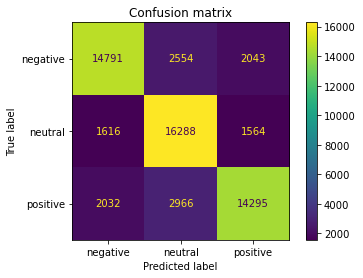

In [12]:
plot_confusion_matrix(based_model_svm, X_test, y_test)
plt.title("Confusion matrix")
plt.plot()

The based model has shown an accuracy score of 78%, which is a good number. However, to avoid overfitting, a validation set would be used, spliting the training set into two subsets: training set 75% and validation set 25%.

## Tuning parameter
For this task, a GridSearchCV function would be used to find the best parameter values on the vectorizer and the SVM algorithm. The parameters that would be tested are: alpha (regularization rate), and max_iter (epchos), ngram_rate (bag of words of one and/or two words, this is tested as two words would be helpful to deal with negation), vocabulary on vectorizer to reduce number of features and the use of the function idf.

In [12]:
test_svm = Pipeline(
                     [
                        ('tfidf', TfidfVectorizer(ngram_range = (1,1), use_idf = True, lowercase = False)), 
                        # Vectorizer to transform text into number
                        # ngram_range: Create a bag of word of one and two words. Two words have been includen as in word done by [], there is no improvement, but
                        #  a way to deal with negations.
                        # lowercase: false, as text is already lowercase format.

                        ('svm', SGDClassifier(loss = 'hinge', shuffle = True, random_state = 1, early_stopping = True)) 
                        # Support Vector Machine
                        # loss = hinge is Suppor Vector Machine
                        # early_stopping: terminate training when validation score is not improving
                        # shuffle: shuffled after each epoch
                        # according to documentation, l1_ratio = 0 is l2, default = 1.5
                     ]
                   )

# Hyper-parameters to be tunned by GridSearchCV
parameters = {
                'svm__alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.5, 0.75, 1], # Regularization rate
                'svm__max_iter': [1, 10, 50, 100, 500, 1000, 1500, 2000] # Epchos
             }

# Cross Validation
# This will split the data into train 75% and validation 25%
kfolds = StratifiedKFold(n_splits = 4, shuffle = True, random_state=1) 

grid_svm = GridSearchCV(test_svm, 
                        param_grid = parameters, 
                        cv = kfolds,
                        scoring = 'accuracy',
                        n_jobs = -1, # Use all CPU
                        return_train_score = True
                        )

### Tunning parameters with l2 regularization

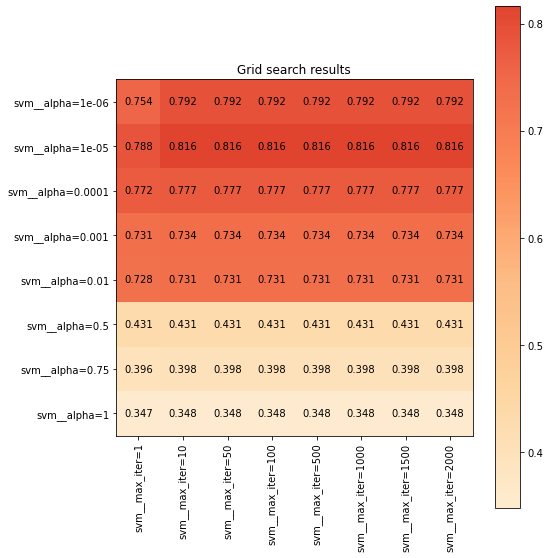

In [14]:
# Set regularization type
test_svm['svm'].penalty = 'l2'
test_svm['svm'].l1_ratio = 0

# Train model to find best learning rate and epchos values with l2 regularizacion
grid_svm.fit(X_train, y_train)

# Ploting results, reference [7]
figure(figsize=(8, 8))
plot.grid_search(grid_svm.cv_results_, change=('svm__alpha', 'svm__max_iter'))
plt.title("Grid search results")
plt.xticks(rotation=90)
plt.show()

In [15]:
# Printing better parameters
print("Best parameters according to GridSearchCV:")
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_svm.best_params_[param_name]))

Best parameters according to GridSearchCV:
svm__alpha: 1e-05
svm__max_iter: 10


In [16]:
# Plot alpha learning with
# It seems that better max_iter number is 10, probably affected by the early_stopping parameter
#   set on model, tho it gives good accuracy scores.
test_svm['svm'].max_iter = 10
val_train, val_test = validation_curve(test_svm, X_train, y_train, 'svm__alpha', parameters['svm__alpha'], cv = kfolds, scoring="accuracy")

C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=svm__alpha, param_range=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.5, 0.75, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


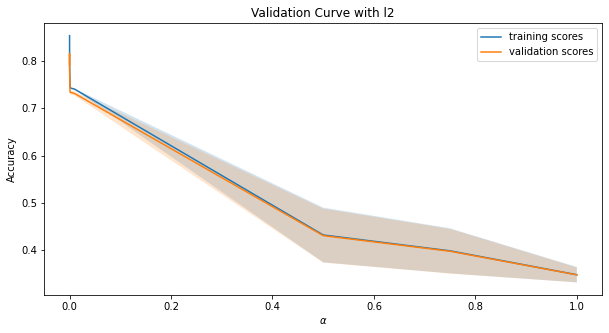

In [17]:
# Plotting results from validation
figure(figsize=(10, 5))
plot_with_err(parameters['svm__alpha'], val_train, label="training scores")
plot_with_err(parameters['svm__alpha'], val_test, label="validation scores")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy")
plt.title("Validation Curve with l2")
plt.legend()

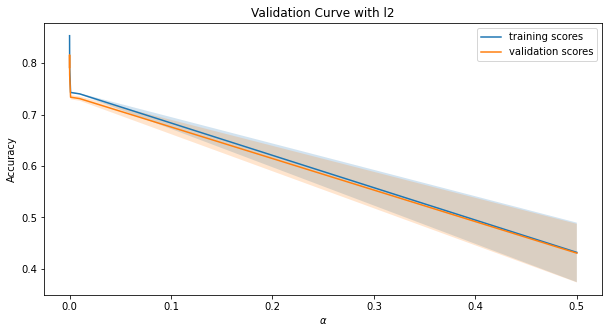

In [18]:
# Zoom in
figure(figsize=(10, 5))
plot_with_err(parameters['svm__alpha'][:6], val_train[:6], label="training scores")
plot_with_err(parameters['svm__alpha'][:6], val_test[:6], label="validation scores")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy")
plt.title("Validation Curve with l2")
plt.legend()

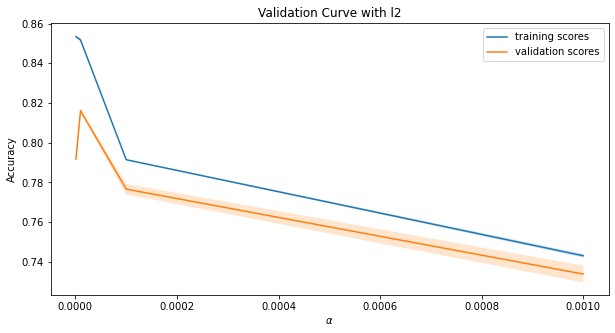

In [19]:
# Zoom in
figure(figsize=(10, 5))
plot_with_err(parameters['svm__alpha'][:4], val_train[:4], label="training scores")
plot_with_err(parameters['svm__alpha'][:4], val_test[:4], label="validation scores")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy")
plt.title("Validation Curve with l2")
plt.legend()

In [20]:
# Print all accuraacy scores from GridSearchCV
for i in range(len(grid_svm.cv_results_['mean_train_score'])):
    if grid_svm.cv_results_['params'][i]['svm__alpha'] <= 0.001 and grid_svm.cv_results_['params'][i]['svm__alpha'] >= 0.00001:
        print(str(i) + " Train: %0.4f (+/- %0.4f)" % (grid_svm.cv_results_['mean_train_score'][i], grid_svm.cv_results_['std_train_score'][i] * 2), end = ' ')
        print("Test: %0.4f (+/- %0.4f)" % (grid_svm.cv_results_['mean_test_score'][i], grid_svm.cv_results_['std_test_score'][i] * 2), end = ' ')
        diff = abs(grid_svm.cv_results_['std_test_score'][i] - grid_svm.cv_results_['std_train_score'][i])
        diff2 = abs(grid_svm.cv_results_['mean_test_score'][i] - grid_svm.cv_results_['mean_train_score'][i])
        print('Diff: ~%0.4f (+/- %0.4f)' % (diff2, diff), end = ' ')
        print('Parameters tunned:', grid_svm.cv_results_['params'][i])

8 Train: 0.8203 (+/- 0.0039) Test: 0.7883 (+/- 0.0070) Diff: ~0.0320 (+/- 0.0016) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 1}
9 Train: 0.8517 (+/- 0.0015) Test: 0.8161 (+/- 0.0018) Diff: ~0.0356 (+/- 0.0002) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 10}
10 Train: 0.8517 (+/- 0.0015) Test: 0.8161 (+/- 0.0018) Diff: ~0.0356 (+/- 0.0002) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 50}
11 Train: 0.8517 (+/- 0.0015) Test: 0.8161 (+/- 0.0018) Diff: ~0.0356 (+/- 0.0002) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 100}
12 Train: 0.8517 (+/- 0.0015) Test: 0.8161 (+/- 0.0018) Diff: ~0.0356 (+/- 0.0002) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 500}
13 Train: 0.8517 (+/- 0.0015) Test: 0.8161 (+/- 0.0018) Diff: ~0.0356 (+/- 0.0002) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 1000}
14 Train: 0.8517 (+/- 0.0015) Test: 0.8161 (+/- 0.0018) Diff: ~0.0356 (+/- 0.0002) Parameters tunned: {'svm__alpha': 1e-05, 'svm_

Candidate learning rate: between 1e-5 and 1e-3

Now, plotting learning curve plot to see the behave of the model [9].

C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration rea


Last scores: [0.85269954 0.85063582 0.85095029 0.85160872] [0.81586085 0.81524175 0.81497096 0.817359  ]


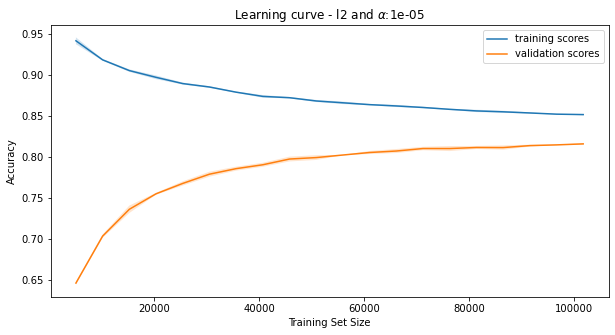

In [21]:
# With best parameters, plot learning curve
test_svm['svm'].alpha = 1e-5
test_svm['svm'].max_iter = 10

figure(figsize=(10, 5))
plot_learning_curve(test_svm, kfolds, X_train, y_train)
plt.title(r"Learning curve - l2 and $\alpha$:" + str(test_svm['svm'].alpha))
plt.show()

C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration rea


Last scores: [0.83256353 0.83084377 0.82946795 0.83114841] [0.80489387 0.80433373 0.80624429 0.80706978]


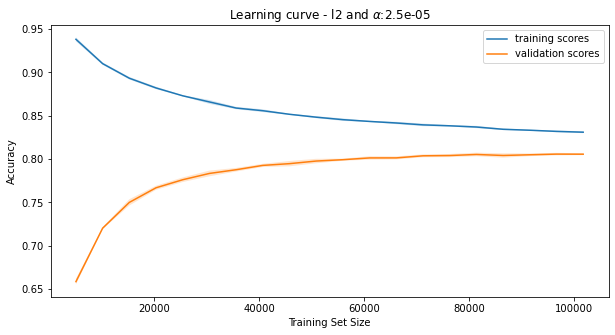

In [22]:
# With best parameters, plot learning curve
test_svm['svm'].alpha = 2.5e-5
test_svm['svm'].max_iter = 10

figure(figsize=(10, 5))
plot_learning_curve(test_svm, kfolds, X_train, y_train)
plt.title(r"Learning curve - l2 and $\alpha$:" + str(test_svm['svm'].alpha))
plt.show()

C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration rea


Last scores: [0.79180015 0.79146603 0.79093536 0.79154465] [0.77635613 0.7723467  0.77879654 0.7793567 ]


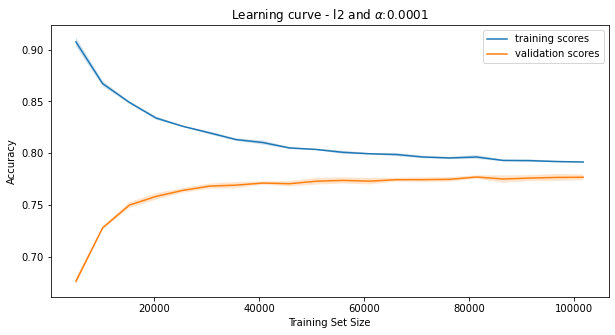

In [24]:
# With best parameters, plot learning curve
test_svm['svm'].alpha = 1e-4
test_svm['svm'].max_iter = 10

figure(figsize=(10, 5))
plot_learning_curve(test_svm, kfolds, X_train, y_train)
plt.title(r"Learning curve - l2 and $\alpha$:" + str(test_svm['svm'].alpha))
plt.show()

C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration rea


Last scores: [0.81254545 0.81120895 0.80975452 0.81096327] [0.79130307 0.78867925 0.79339014 0.79424511]


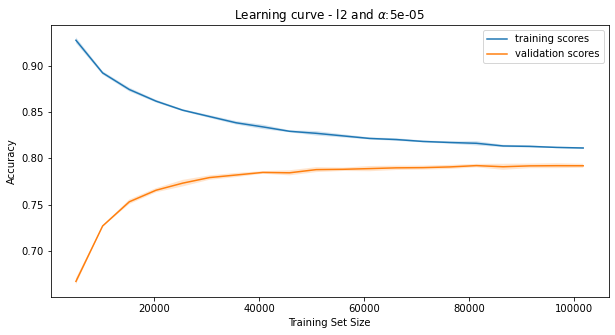

In [23]:
# With best parameters, plot learning curve
test_svm['svm'].alpha = 5e-5
test_svm['svm'].max_iter = 10

figure(figsize=(10, 5))
plot_learning_curve(test_svm, kfolds, X_train, y_train)
plt.title(r"Learning curve - l2 and $\alpha$:" + str(test_svm['svm'].alpha))
plt.show()

C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "



Last scores: [0.7421333  0.74323395 0.74421667 0.74318481] [0.73295991 0.72732901 0.73769863 0.73719744]


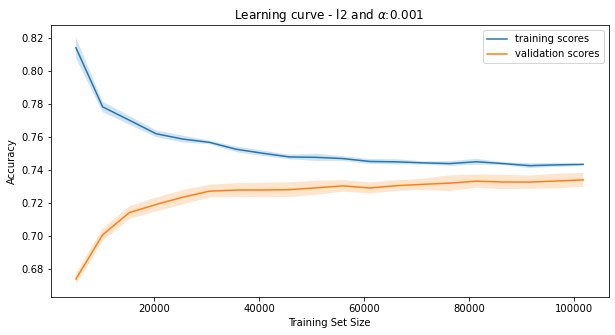

In [25]:
# With best parameters, plot learning curve
test_svm['svm'].alpha = 1e-3
test_svm['svm'].max_iter = 10

figure(figsize=(10, 5))
plot_learning_curve(test_svm, kfolds, X_train, y_train)
plt.title(r"Learning curve - l2 and $\alpha$:" + str(test_svm['svm'].alpha))
plt.show()

Best Parameters for model using l2:
- Learning rate: 1e-5
- Epchos: 10
- With accuracy score for train 0.85 and test 0.81.

### Tunning parameters with l1 regularization

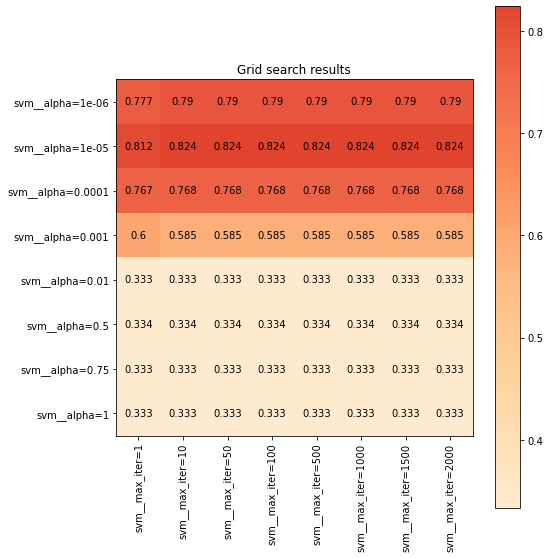

In [26]:
# Set regularization type
test_svm['svm'].penalty = 'l1'
test_svm['svm'].l1_ratio = 1

# Train model to find best learning rate and epchos values with l2 regularizacion
grid_svm.fit(X_train, y_train)

# Ploting results, reference [7]
figure(figsize=(8, 8))
plot.grid_search(grid_svm.cv_results_, change=('svm__alpha', 'svm__max_iter'))
plt.title("Grid search results")
plt.xticks(rotation=90)
plt.show()

In [27]:
# Printing better parameters
print("Best parameters according to GridSearchCV:")
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_svm.best_params_[param_name]))

Best parameters according to GridSearchCV:
svm__alpha: 1e-05
svm__max_iter: 10


In [28]:
# Plot alpha learning with 
test_svm['svm'].max_iter = 10
val_train, val_test = validation_curve(test_svm, X_train, y_train, 'svm__alpha', parameters['svm__alpha'], cv = kfolds, scoring="accuracy")

C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=svm__alpha, param_range=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.5, 0.75, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


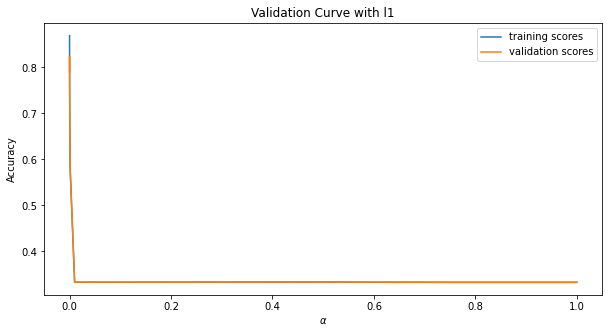

In [29]:
# Plotting results from validation
figure(figsize=(10, 5))
plot_with_err(parameters['svm__alpha'], val_train, label="training scores")
plot_with_err(parameters['svm__alpha'], val_test, label="validation scores")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy")
plt.title("Validation Curve with l1")
plt.legend()

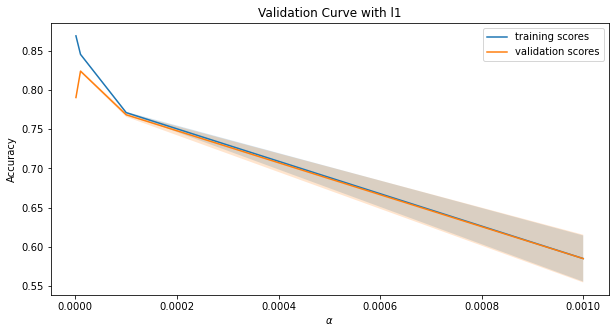

In [30]:
# Zoom in
figure(figsize=(10, 5))
plot_with_err(parameters['svm__alpha'][:4], val_train[:4], label="training scores")
plot_with_err(parameters['svm__alpha'][:4], val_test[:4], label="validation scores")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy")
plt.title("Validation Curve with l1")
plt.legend()

# Greather than 0.0001, the two lines are close to each other and both errors are large, it is a sign of underfitting.
#  Therfore, learning rate below 0.0001 is good candidates. Learning rate 1e-6 not included as it showed a lower accuracy comapring
#  comparing to 1e-5.

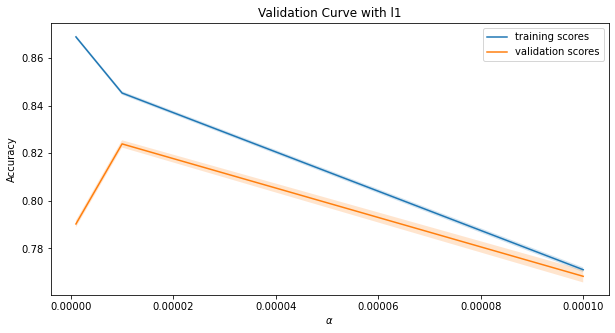

In [31]:
# Zoom in
figure(figsize=(10, 5))
plot_with_err(parameters['svm__alpha'][:3], val_train[:3], label="training scores")
plot_with_err(parameters['svm__alpha'][:3], val_test[:3], label="validation scores")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy")
plt.title("Validation Curve with l1")
plt.legend()

In [32]:
# Print all accuraacy scores from GridSearchCV
for i in range(len(grid_svm.cv_results_['mean_train_score'])):
    if grid_svm.cv_results_['params'][i]['svm__alpha'] == 0.00001:
        print(str(i) + " Train: %0.4f (+/- %0.4f)" % (grid_svm.cv_results_['mean_train_score'][i], grid_svm.cv_results_['std_train_score'][i] * 2), end = ' ')
        print("Test: %0.4f (+/- %0.4f)" % (grid_svm.cv_results_['mean_test_score'][i], grid_svm.cv_results_['std_test_score'][i] * 2), end = ' ')
        diff = abs(grid_svm.cv_results_['std_test_score'][i] - grid_svm.cv_results_['std_train_score'][i])
        diff2 = abs(grid_svm.cv_results_['mean_test_score'][i] - grid_svm.cv_results_['mean_train_score'][i])
        print('Diff: ~%0.4f (+/- %0.4f)' % (diff2, diff), end = ' ')
        print('Parameters tunned:', grid_svm.cv_results_['params'][i])

8 Train: 0.8358 (+/- 0.0009) Test: 0.8121 (+/- 0.0021) Diff: ~0.0237 (+/- 0.0006) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 1}
9 Train: 0.8453 (+/- 0.0015) Test: 0.8240 (+/- 0.0031) Diff: ~0.0214 (+/- 0.0008) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 10}
10 Train: 0.8453 (+/- 0.0015) Test: 0.8240 (+/- 0.0031) Diff: ~0.0214 (+/- 0.0008) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 50}
11 Train: 0.8453 (+/- 0.0015) Test: 0.8240 (+/- 0.0031) Diff: ~0.0214 (+/- 0.0008) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 100}
12 Train: 0.8453 (+/- 0.0015) Test: 0.8240 (+/- 0.0031) Diff: ~0.0214 (+/- 0.0008) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 500}
13 Train: 0.8453 (+/- 0.0015) Test: 0.8240 (+/- 0.0031) Diff: ~0.0214 (+/- 0.0008) Parameters tunned: {'svm__alpha': 1e-05, 'svm__max_iter': 1000}
14 Train: 0.8453 (+/- 0.0015) Test: 0.8240 (+/- 0.0031) Diff: ~0.0214 (+/- 0.0008) Parameters tunned: {'svm__alpha': 1e-05, 'svm_

Candidate learning rates: 1e-5.

Now, plotting learning curve plot to see the behave of the model [9].


Last scores: [0.84598754 0.84422846 0.84380589 0.84509326] [0.82152123 0.82379127 0.82443468 0.82296058]


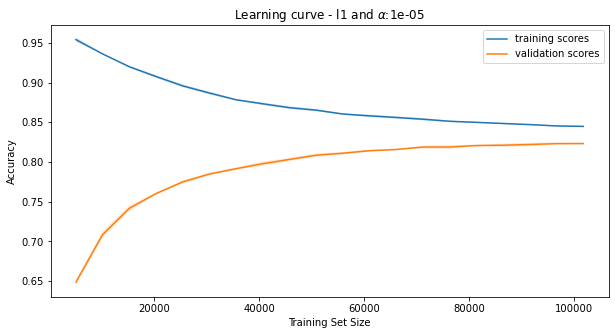

In [33]:
# With best parameters, plot learning curve
# Curves do not converge, suggesting the model is overfitting.
test_svm['svm'].alpha = 1e-5
test_svm['svm'].max_iter = 10

figure(figsize=(10, 5))
plot_learning_curve(test_svm, kfolds, X_train, y_train)
plt.title(r"Learning curve - l1 and $\alpha$:" + str(test_svm['svm'].alpha))
plt.show()

C:\Users\acjimenez\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "



Last scores: [0.82368954 0.82195012 0.82233338 0.82309008] [0.81317807 0.81350236 0.81485303 0.81449925]


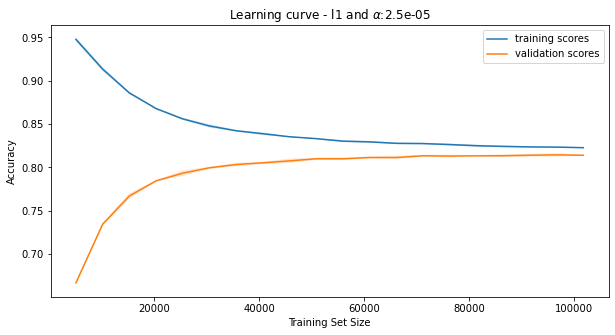

In [34]:
# With best parameters, plot learning curve
# Curves do not converge, suggesting the model is overfitting.
test_svm['svm'].alpha = 2.5e-5
test_svm['svm'].max_iter = 10

figure(figsize=(10, 5))
plot_learning_curve(test_svm, kfolds, X_train, y_train)
plt.title(r"Learning curve - l1 and $\alpha$:" + str(test_svm['svm'].alpha))
plt.show()


Last scores: [0.80098862 0.80131292 0.79952436 0.80032037] [0.79416274 0.79321934 0.79828415 0.79548336]


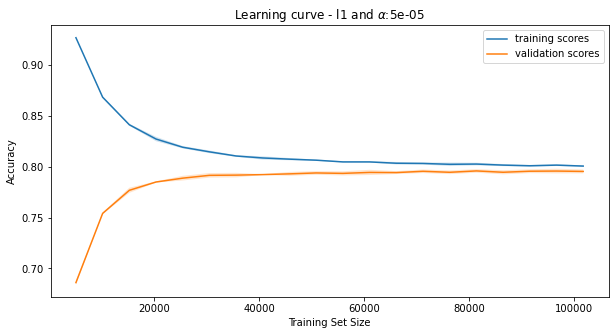

In [35]:
# With best parameters, plot learning curve
# Curves do not converge, suggesting the model is overfitting.
test_svm['svm'].alpha = 5e-5
test_svm['svm'].max_iter = 10

figure(figsize=(10, 5))
plot_learning_curve(test_svm, kfolds, X_train, y_train)
plt.title(r"Learning curve - l1 and $\alpha$:" + str(test_svm['svm'].alpha))
plt.show()

Best Parameters for model using l1:
- Learning rate: 1e-5
- Epchos: 10

### l2 or l1?
Comparing with best parameters, setting penalty to l1 gets a better accuracy number. Therefore l1 will be used.

## Evaluate model chosen from previous GridSearchCV
The followin steps were perform to evalute model:
1. Create model.
2. Run a simple evaluation with StratifiedKFold function (keep class distribution).
3. Run a repeated evaluation for a harness test using ReapeatedStratifiedKFold function.
4. Display results 

In [29]:
# Create model
learning_rate = 1e-5
epchos = 10
penalty = 'l1'
l1_ratio = 0 #equivalent to l2
sentiment_model = create_model(learning_rate, epchos, penalty, l1_ratio)

In [24]:
# Simple evaluation
# Validate model with a validation split (25%)
scores = cross_val_score(sentiment_model,
                         X_train,
                         y_train,
                         cv = kfolds)

# Mean score
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

Accuracy: 0.8236 (+/- 0.0023)


In [25]:
# Validate with repeated folds
# Test harness, consistent way to evaluate machine learning algorithms on a dataset to evaluate predictions.
#  Reference [8].
repeats = np.arange(1,16)
results = list()

print("Validation on repeated " + str(len(repeats)) + "-folds")
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(sentiment_model, X_train, y_train, r)

	# summarize
	print('> %d >> mean = %.4f' % (r, np.mean(scores)))

	# store
	results.append(scores)

Validation on repeated 15-folds
> 1 >> mean = 0.8236
> 2 >> mean = 0.8238
> 3 >> mean = 0.8237
> 4 >> mean = 0.8238
> 5 >> mean = 0.8237
> 6 >> mean = 0.8236
> 7 >> mean = 0.8235
> 8 >> mean = 0.8234
> 9 >> mean = 0.8234
> 10 >> mean = 0.8235
> 11 >> mean = 0.8236
> 12 >> mean = 0.8235
> 13 >> mean = 0.8235
> 14 >> mean = 0.8235
> 15 >> mean = 0.8234


C:\Users\acjimenez\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


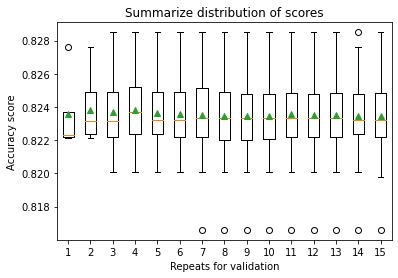

In [26]:
# Plot evaluation results
plt.boxplot(results, labels = repeats, showmeans = True)
plt.title("Summarize distribution of scores")
plt.ylabel("Accuracy score")
plt.xlabel("Repeats for validation")
plt.show()

where:

- Orange line: median
- Green triangle: mean

If median and mean roughly coincide, it suggests a reasonable symmetric distribution and that the mean may capture the central tendency well. Test harness and algorithm appears to be a **good choice** [8].

## Predict on test set

In [30]:
# Train it on the entire training data set
sentiment_model.fit(X_train, y_train)
print('Train accuracy:', sentiment_model.score(X_train, y_train))
print('Test accuracy:', sentiment_model.score(X_test, y_test))

Train accuracy: 0.84046050207108
Test accuracy: 0.8277700390376447


In [32]:
# Full report
predicted = sentiment_model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

    negative       0.82      0.84      0.83     19388
     neutral       0.86      0.81      0.84     19468
    positive       0.81      0.83      0.82     19293

    accuracy                           0.83     58149
   macro avg       0.83      0.83      0.83     58149
weighted avg       0.83      0.83      0.83     58149



[]

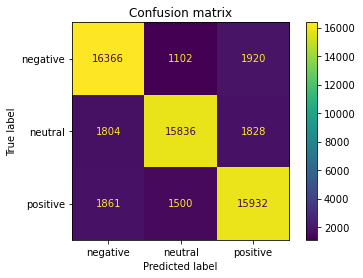

In [31]:
plot_confusion_matrix(sentiment_model, X_test, y_test)
plt.title("Confusion matrix")
plt.plot()

## Save model   

In [33]:
# Save the model to disk
model_name = '../model/my_sentiment_model.sav'
joblib.dump(sentiment_model, model_name)

['../model/my_sentiment_model.sav']

## Label covid vaccine tweets from Ireland
Label tweets from inical collection

In [34]:
# Get all tweets from ie
data_a = tweet_data.tweet_data()
all_ie_tweets = data_a.get_unlabelled_tweets(False)
all_ie_tweets.info()
del data_a

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155950 entries, 0 to 155949
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tweet_id         155950 non-null  object
 1   original_text    155950 non-null  object
 2   normalized_text  155950 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [41]:
all_ie_tweets.shape

(155950, 4)

In [35]:
# Remove all tweets with no characters
# Empty tweets would be classified as neutral as the lack of verbs/words with sentiment
all_ie_tweets['count_length'] = all_ie_tweets['normalized_text'].apply(count_length)
cond = all_ie_tweets['count_length'] > 2
all_ie_tweets_2 = all_ie_tweets[cond].copy()
display(all_ie_tweets_2[['tweet_id', 'normalized_text']].head(5))

,tweet_id,normalized_text
0,1216683812287057920,flu highly infectious acute respiratory illnes...
1,1216683996068876289,retweet flu highly infectious acute respirator...
2,1217877514149879808,ask journalist pneumonia outbreak answer serio...
3,1220124992207228928,watch documentary outbreak happen sad see argu...
4,1220350863975288839,outbreak researcher start develop potential pe...


In [43]:
all_ie_tweets_2.shape

(141886, 6)

In [36]:
# Load sentiment model
sentiment_model = joblib.load(model_name) 

In [37]:
# Label tweets
all_ie_tweets_2['label'] = sentiment_model.predict(all_ie_tweets_2['normalized_text'])

# Label meaning:
# 	label   	label_id
#   neutral	        0
#   positive	    1
#   negative	    2

cond_neutral = all_ie_tweets_2.label == 'neutral'
all_ie_tweets_2.loc[cond_neutral,'label_id'] = 0

cond_positive = all_ie_tweets_2.label == 'positive'
all_ie_tweets_2.loc[cond_positive,'label_id'] = 1

cond_negative = all_ie_tweets_2.label == 'negative'
all_ie_tweets_2.loc[cond_negative,'label_id'] = 2

all_ie_tweets_2[['tweet_id', 'normalized_text', 'label', 'label_id']].head(5)

,tweet_id,normalized_text,label,label_id
0,1216683812287057920,flu highly infectious acute respiratory illnes...,negative,2.0
1,1216683996068876289,retweet flu highly infectious acute respirator...,negative,2.0
2,1217877514149879808,ask journalist pneumonia outbreak answer serio...,positive,1.0
3,1220124992207228928,watch documentary outbreak happen sad see argu...,positive,1.0
4,1220350863975288839,outbreak researcher start develop potential pe...,negative,2.0


In [38]:
# Upgrade sentiment into label
data_a = tweet_data.tweet_data()
count_tweets = len(all_ie_tweets_2)
for index in range(count_tweets):
    row_df = all_ie_tweets_2.iloc[index]
    tweet_id = row_df['tweet_id']
    label_id = row_df['label_id']
    label = row_df['label']
    data_a.insert_tweet_polarity_score(str(tweet_id), int(label_id), label)

del data_a

In [44]:
# Tweets with no length would be classified as neutral
all_ie_tweets_3 = all_ie_tweets[~cond].copy()
all_ie_tweets_3['label'] = 'neutral'
all_ie_tweets_3['label_id'] = 0
all_ie_tweets_3.shape

(14064, 6)

In [39]:
# Upgrade sentiment into label
data_a = tweet_data.tweet_data()
count_tweets = len(all_ie_tweets_3)
for index in range(count_tweets):
    row_df = all_ie_tweets_3.iloc[index]
    tweet_id = row_df['tweet_id']
    label_id =  row_df['label_id']
    label =  row_df['label']
    data_a.insert_tweet_polarity_score(str(tweet_id), int(label_id), label)
    
del data_a

## References
1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier
2. https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
7. https://sklearn-evaluation.readthedocs.io/en/stable/user_guide/grid_search.html
8. https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/
9. https://mlcourse.ai/articles/topic4-part5-validation/